In [1]:
# Import all required libraries
!pip install folium

%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import folium
import sklearn.model_selection as model_selection
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score, precision_score, recall_score

# Retrieve data from source, drop unrequired columns and rename columns appropriately

data = pd.read_csv("https://s3.us.cloud-object-storage.appdomain.cloud/cf-courses-data/CognitiveClass/DP0701EN/version-2/Data-Collisions.csv",low_memory=False)
print('done')

     |████████████████████████████████| 102kB 9.0MB/s ta 0:00:011
done


In [2]:
# Drop columns that I do not need for my project
data = data.drop(columns=['OBJECTID','INCKEY','COLDETKEY','REPORTNO','STATUS','INTKEY','LOCATION','EXCEPTRSNCODE','EXCEPTRSNDESC','SEVERITYCODE.1','SEVERITYDESC','INCDATE','SDOT_COLCODE','SDOT_COLDESC','SDOTCOLNUM','ST_COLCODE','ST_COLDESC','SEGLANEKEY','CROSSWALKKEY'])

In [3]:
# High level analysis of the data 
data.iloc[:,:10].describe(include='all')

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,INCDTTM
count,194673.000000,189339.000000,189339.000000,192747,189769,194673.000000,194673.000000,194673.000000,194673.000000,194673
unique,NaN,NaN,NaN,3,10,NaN,NaN,NaN,NaN,162058
top,NaN,NaN,NaN,Block,Parked Car,NaN,NaN,NaN,NaN,11/2/2006
freq,NaN,NaN,NaN,126926,47987,NaN,NaN,NaN,NaN,96
mean,1.298901,-122.330518,47.619543,NaN,NaN,2.444427,0.037139,0.028391,1.920780,NaN
std,0.457778,0.029976,0.056157,NaN,NaN,1.345929,0.198150,0.167413,0.631047,NaN
min,1.000000,-122.419091,47.495573,NaN,NaN,0.000000,0.000000,0.000000,0.000000,NaN
25%,1.000000,-122.348673,47.575956,NaN,NaN,2.000000,0.000000,0.000000,2.000000,NaN
50%,1.000000,-122.330224,47.615369,NaN,NaN,2.000000,0.000000,0.000000,2.000000,NaN
75%,2.000000,-122.311937,47.663664,NaN,NaN,3.000000,0.000000,0.000000,2.000000,NaN


In [4]:
# High level analysis of the data
data.iloc[:,10:].describe(include='all')

,JUNCTIONTYPE,INATTENTIONIND,UNDERINFL,WEATHER,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR
count,188344,29805,189789,189592,189661,189503,4667,9333,194673
unique,7,1,4,11,9,9,1,1,2
top,Mid-Block (not related to intersection),Y,N,Clear,Dry,Daylight,Y,Y,N
freq,89800,29805,100274,111135,124510,116137,4667,9333,187457


In [5]:
# Change Y/N to 0/1

data['INATTENTIONIND'].replace("Y",1,inplace=True)

data['UNDERINFL'].replace("Y",1,inplace=True)
data['UNDERINFL'].replace("N",0,inplace=True)

# AS the column is currently "object" we need to convert the text versions of 0 and 1 to integers
data['UNDERINFL'].replace("1",1,inplace=True)
data['UNDERINFL'].replace("0",0,inplace=True)

data['PEDROWNOTGRNT'].replace("Y",1,inplace=True)

data['SPEEDING'].replace("Y",1,inplace=True)

data['HITPARKEDCAR'].replace("Y",1,inplace=True)
data['HITPARKEDCAR'].replace("N",0,inplace=True)

In [6]:
# Replace NULL values

mean_x = data['X'].mean(axis=0)
print(mean_x)
data['X'].fillna(mean_x,inplace=True)

mean_y = data['Y'].mean(axis=0)
print(mean_y)
data['Y'].fillna(mean_y,inplace=True)

data = data.dropna(subset=['ADDRTYPE','COLLISIONTYPE','JUNCTIONTYPE'])

data['INATTENTIONIND'].fillna(0,inplace=True)

data['UNDERINFL'].fillna(0,inplace=True)

data['WEATHER'].fillna("Unknown",inplace=True)

data['ROADCOND'].fillna("Unknown",inplace=True)

data['LIGHTCOND'].fillna("Unknown",inplace=True)

data['PEDROWNOTGRNT'].fillna(0,inplace=True)

data['SPEEDING'].fillna(0,inplace=True)
# Converting SPEEDING to int as it was a float
data.SPEEDING = data.SPEEDING.astype('int64')

-122.33051843904114
47.619542517688615


In [7]:
# Retrieve Date fields as separate fields
data['INCDTTM'] = pd.to_datetime(data['INCDTTM'])
data['Year'] = pd.DatetimeIndex(data['INCDTTM']).year
data['Month'] = pd.DatetimeIndex(data['INCDTTM']).month
data['Day'] = pd.DatetimeIndex(data['INCDTTM']).day
data['DayOfWeek'] = data['INCDTTM'].dt.dayofweek
data['Hours'] = data['INCDTTM'].dt.hour
data['Minutes'] = data['INCDTTM'].dt.minute

# Now I have time periods I can use, I am going to drop the date field
data = data.drop(columns=['INCDTTM'])

In [8]:
data.head()

,SEVERITYCODE,X,Y,ADDRTYPE,COLLISIONTYPE,PERSONCOUNT,PEDCOUNT,PEDCYLCOUNT,VEHCOUNT,JUNCTIONTYPE,...,LIGHTCOND,PEDROWNOTGRNT,SPEEDING,HITPARKEDCAR,Year,Month,Day,DayOfWeek,Hours,Minutes
0,2,-122.323148,47.703140,Intersection,Angles,2,0,0,2,At Intersection (intersection related),...,Daylight,0.0,0,0,2013,3,27,2,14,54
1,1,-122.347294,47.647172,Block,Sideswipe,2,0,0,2,Mid-Block (not related to intersection),...,Dark - Street Lights On,0.0,0,0,2006,12,20,2,18,55
2,1,-122.334540,47.607871,Block,Parked Car,4,0,0,3,Mid-Block (not related to intersection),...,Daylight,0.0,0,0,2004,11,18,3,10,20
3,1,-122.334803,47.604803,Block,Other,3,0,0,3,Mid-Block (not related to intersection),...,Daylight,0.0,0,0,2013,3,29,4,9,26
4,2,-122.306426,47.545739,Intersection,Angles,2,0,0,2,At Intersection (intersection related),...,Daylight,0.0,0,0,2004,1,28,2,8,4


In [9]:
# Provide better Headings for Fields
data.columns = ['SeverityCode','X','Y','LocationType','CollisionType','PersonCount','PedestrianCount','CyclistCount','VehicleCount','JunctionType','DriverInattention','DriverUnderInfluence','Weather','RoadCondition','LightCondition','PedROWNG','DriverSpeeding','HitParkedCar','Year','Month','Day','DayOfWeek','Hours','Minutes']

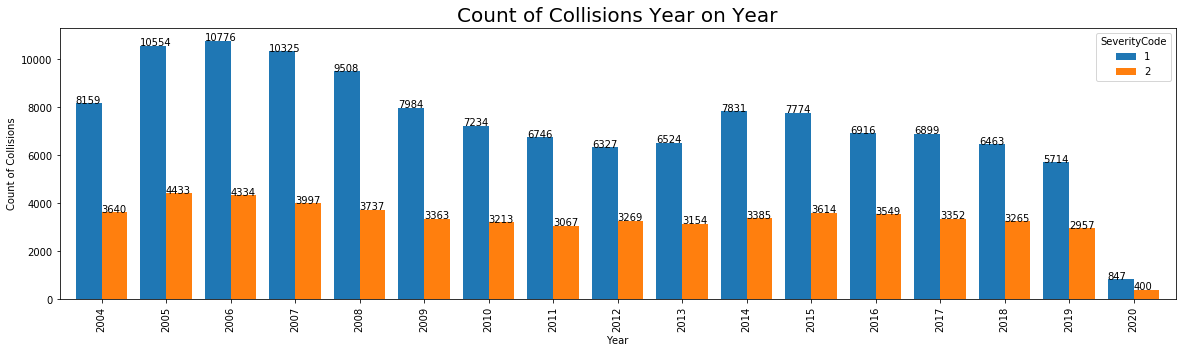

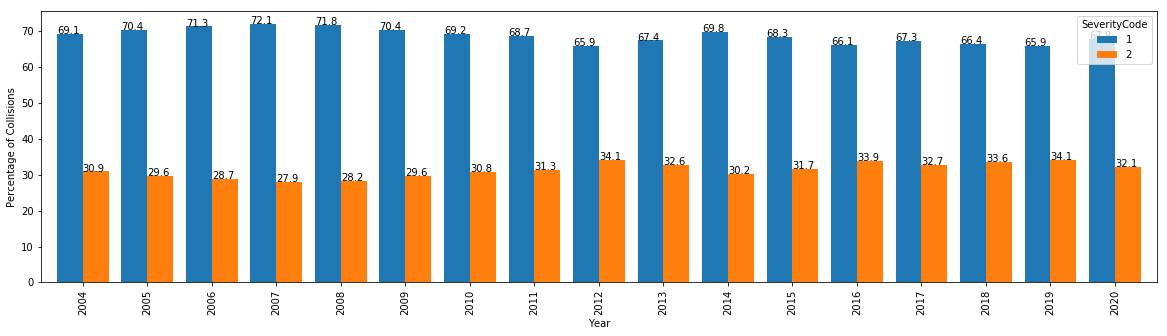

In [10]:
year_pivot = data.pivot_table(
                        index='Year',
                        columns='SeverityCode',
                        aggfunc='size')
year_plot = year_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
year_plot.set_ylabel('Count of Collisions')
year_plot.set_title('Count of Collisions Year on Year', size=20)
for p in year_plot.patches:
    year_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
year_plot

year_pivot = data.pivot_table(
                        index='Year',
                        columns='SeverityCode',
                        aggfunc='size')
year_pivot = year_pivot.div(year_pivot.sum(1),0) * 100
year_pivot = year_pivot.round(1)
year_plot = year_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
year_plot.set_ylabel('Percentage of Collisions')
for p in year_plot.patches:
    year_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

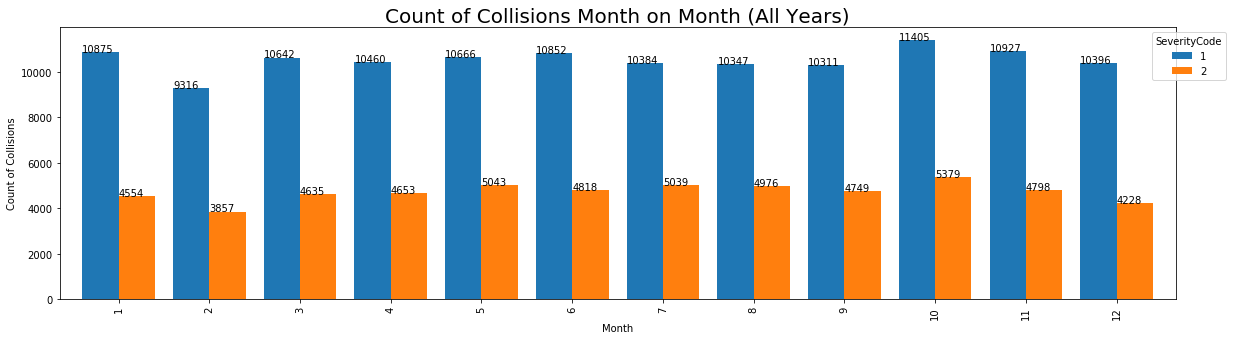

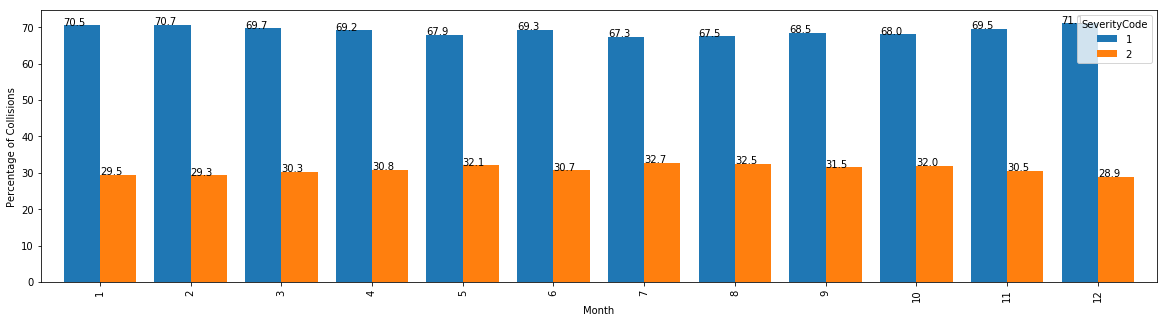

In [11]:
month_pivot = data.pivot_table(
                        index='Month',
                        columns='SeverityCode',
                        aggfunc='size')
month_plot = month_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
month_plot.set_ylabel('Count of Collisions')
month_plot.set_title('Count of Collisions Month on Month (All Years)', size=20)
month_plot.legend(title='SeverityCode',bbox_to_anchor=(1.05, 1.0))
for p in month_plot.patches:
    month_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
month_plot

month_pivot = data.pivot_table(
                        index='Month',
                        columns='SeverityCode',
                        aggfunc='size')
month_pivot = month_pivot.div(month_pivot.sum(1),0) * 100
month_pivot = month_pivot.round(1)
month_plot = month_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
month_plot.set_ylabel('Percentage of Collisions')
for p in month_plot.patches:
    month_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

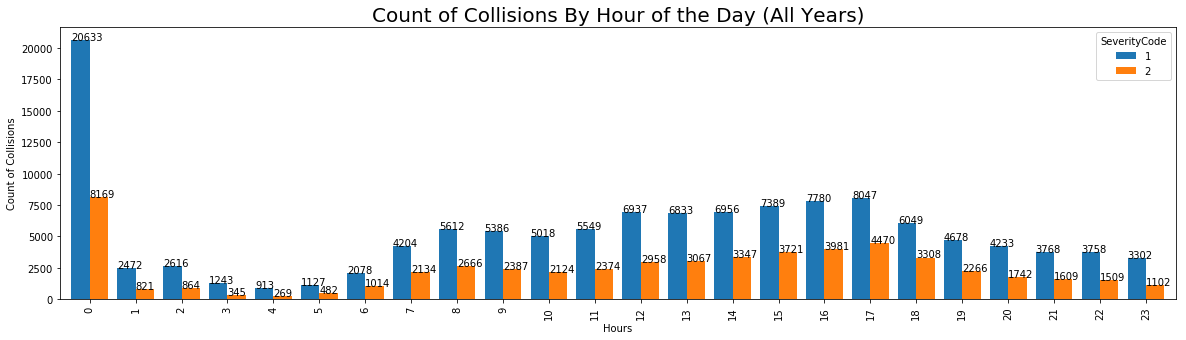

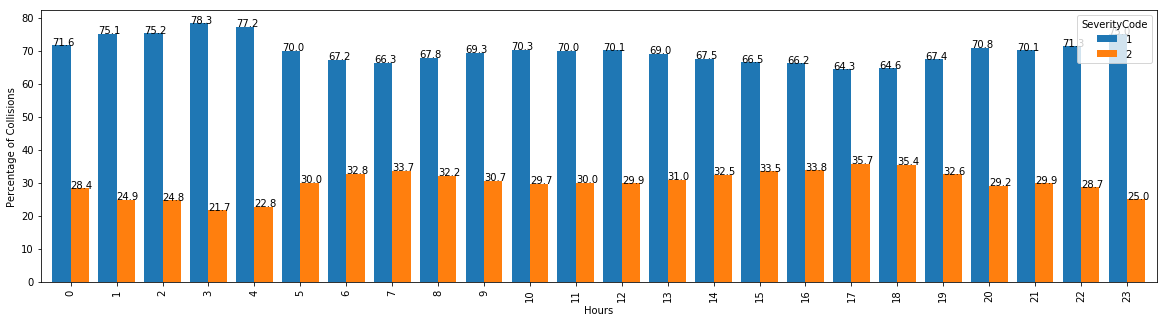

In [12]:
hour_pivot = data.pivot_table(
                        index='Hours',
                        columns='SeverityCode',
                        aggfunc='size')
hour_plot = hour_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
hour_plot.set_ylabel('Count of Collisions')
hour_plot.set_title('Count of Collisions By Hour of the Day (All Years)', size=20)
for p in hour_plot.patches:
    hour_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
hour_plot

hour_pivot = data.pivot_table(
                        index='Hours',
                        columns='SeverityCode',
                        aggfunc='size')
hour_pivot = hour_pivot.div(hour_pivot.sum(1),0) * 100
hour_pivot = hour_pivot.round(1)
hour_plot = hour_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
hour_plot.set_ylabel('Percentage of Collisions')
for p in hour_plot.patches:
    hour_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

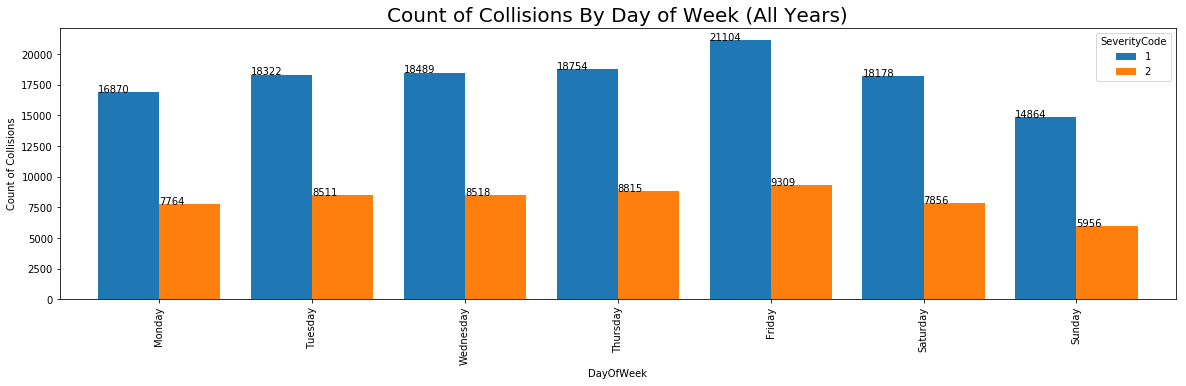

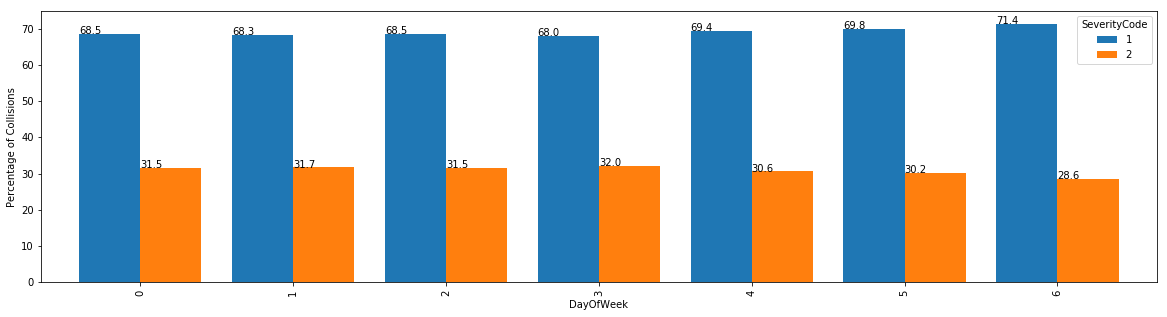

In [13]:
dow_pivot = data.pivot_table(
                        index='DayOfWeek',
                        columns='SeverityCode',
                        aggfunc='size')
dow_plot = dow_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
dow_plot.set_ylabel('Count of Collisions')
dow_plot.set_xticklabels(['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
dow_plot.set_title('Count of Collisions By Day of Week (All Years)', size=20)
for p in dow_plot.patches:
    dow_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
dow_plot

dow_pivot = data.pivot_table(
                        index='DayOfWeek',
                        columns='SeverityCode',
                        aggfunc='size')
dow_pivot = dow_pivot.div(dow_pivot.sum(1),0) * 100
dow_pivot = dow_pivot.round(1)
dow_plot = dow_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
dow_plot.set_ylabel('Percentage of Collisions')
for p in dow_plot.patches:
    dow_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

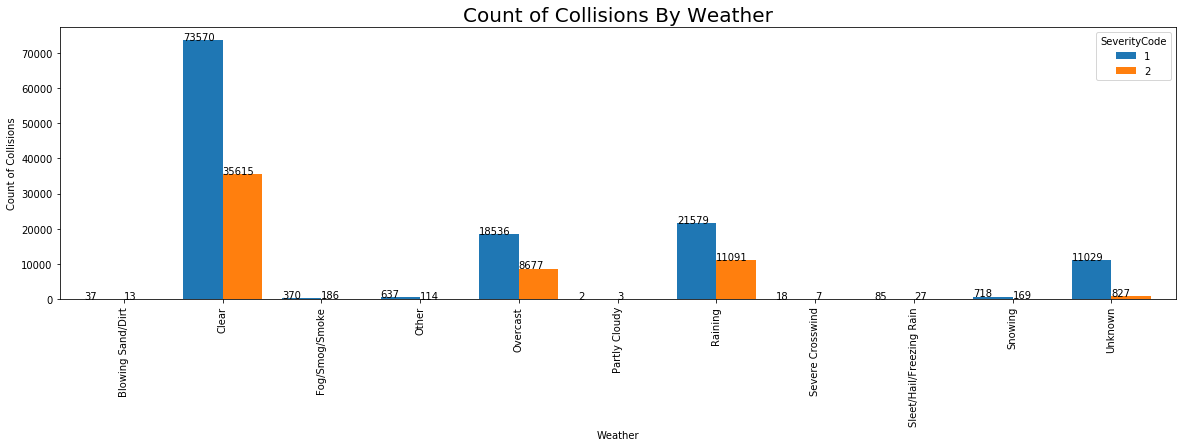

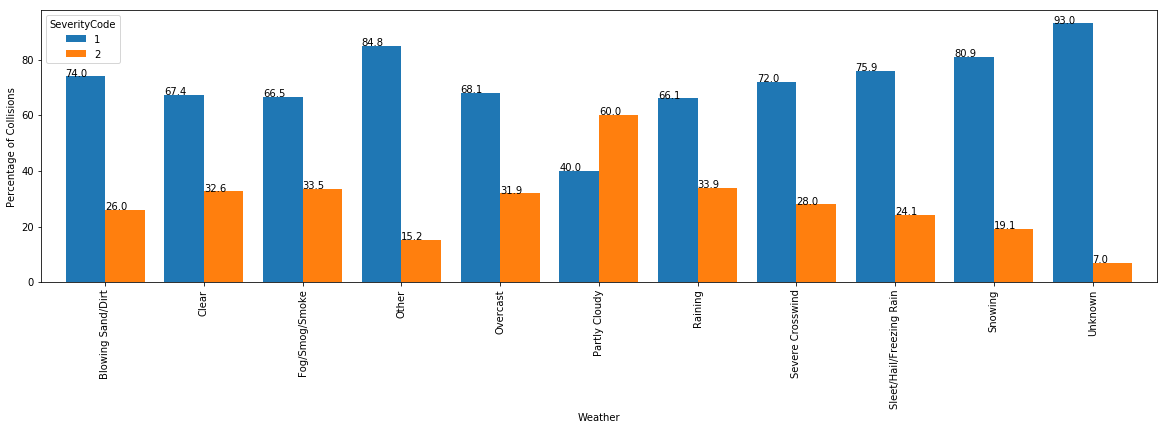

In [14]:
weather_pivot = data.pivot_table(
                        index='Weather',
                        columns='SeverityCode',
                        aggfunc='size')
weather_plot = weather_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
weather_plot.set_ylabel('Count of Collisions')
weather_plot.set_title('Count of Collisions By Weather', size=20)
for p in weather_plot.patches:
    weather_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
weather_plot

weather_pivot = data.pivot_table(
                        index='Weather',
                        columns='SeverityCode',
                        aggfunc='size')
weather_pivot = weather_pivot.div(weather_pivot.sum(1),0) * 100
weather_pivot = weather_pivot.round(1)
weather_plot = weather_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
weather_plot.set_ylabel('Percentage of Collisions')
for p in weather_plot.patches:
    weather_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

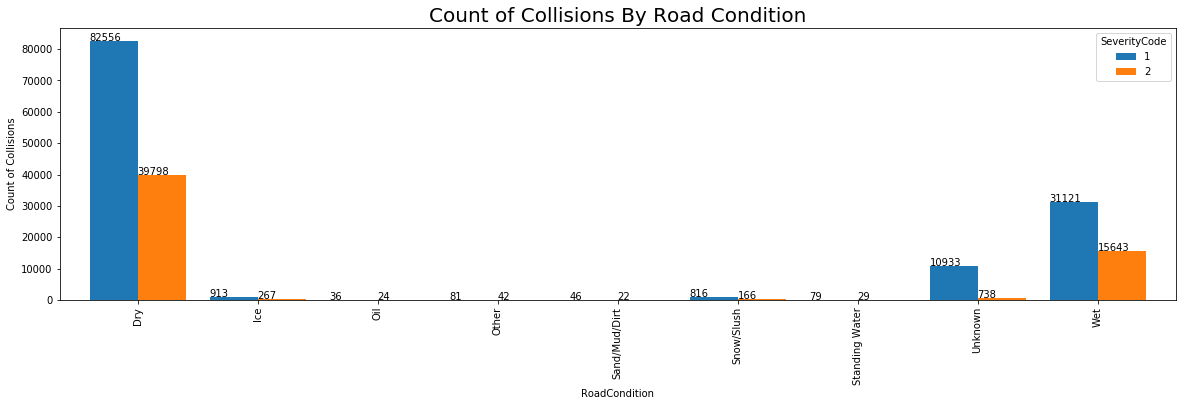

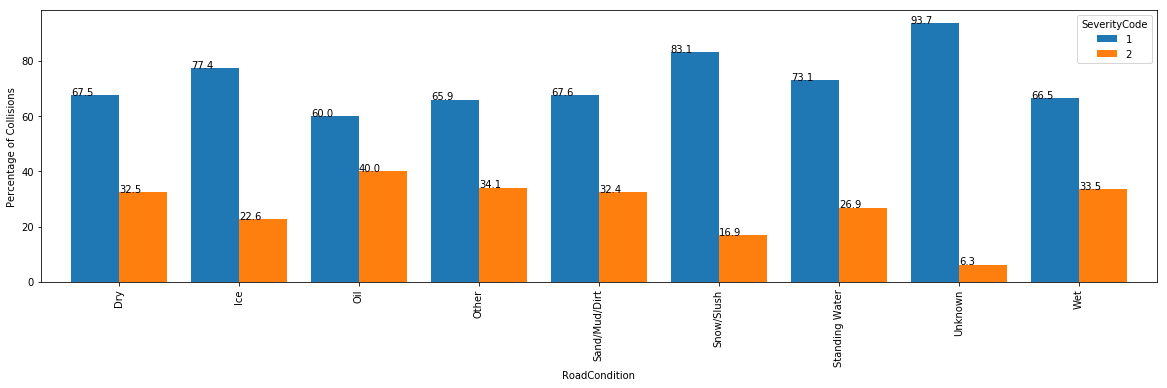

In [15]:
road_pivot = data.pivot_table(
                        index='RoadCondition',
                        columns='SeverityCode',
                        aggfunc='size')
road_plot = road_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
road_plot.set_ylabel('Count of Collisions')
road_plot.set_title('Count of Collisions By Road Condition', size=20)
for p in road_plot.patches:
    road_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
road_plot

road_pivot = data.pivot_table(
                        index='RoadCondition',
                        columns='SeverityCode',
                        aggfunc='size')
road_pivot = road_pivot.div(road_pivot.sum(1),0) * 100
road_pivot = road_pivot.round(1)
road_plot = road_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
road_plot.set_ylabel('Percentage of Collisions')
for p in road_plot.patches:
    road_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

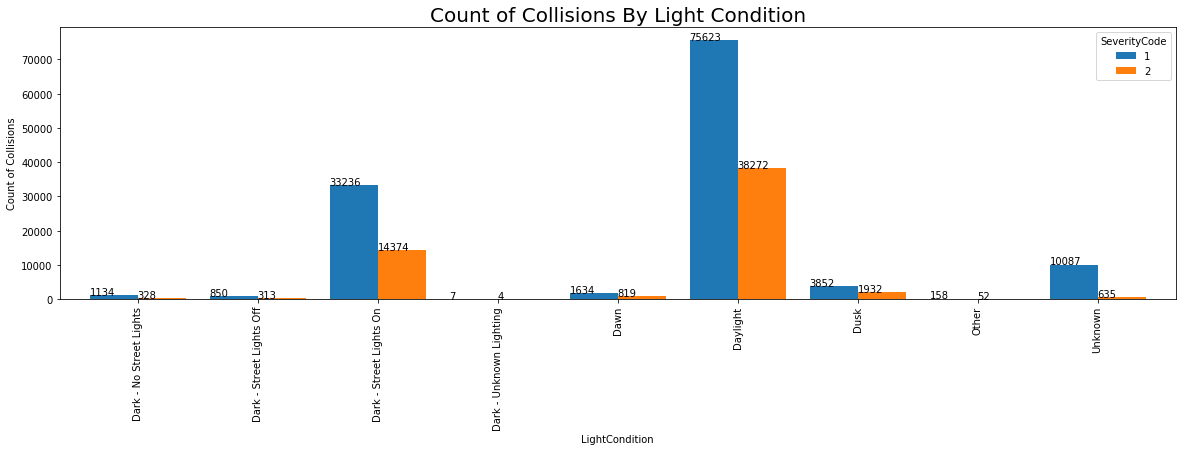

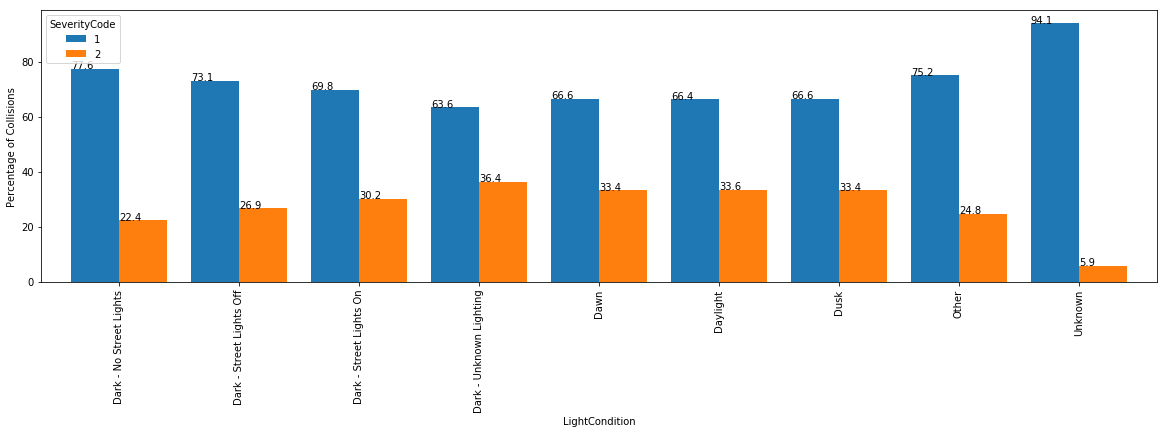

In [16]:
light_pivot = data.pivot_table(
                        index='LightCondition',
                        columns='SeverityCode',
                        aggfunc='size')
light_plot = light_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
light_plot.set_ylabel('Count of Collisions')
light_plot.set_title('Count of Collisions By Light Condition', size=20)
for p in light_plot.patches:
    light_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
light_plot

light_pivot = data.pivot_table(
                        index='LightCondition',
                        columns='SeverityCode',
                        aggfunc='size')
light_pivot = light_pivot.div(light_pivot.sum(1),0) * 100
light_pivot = light_pivot.round(1)
light_plot = light_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
light_plot.set_ylabel('Percentage of Collisions')
for p in light_plot.patches:
    light_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

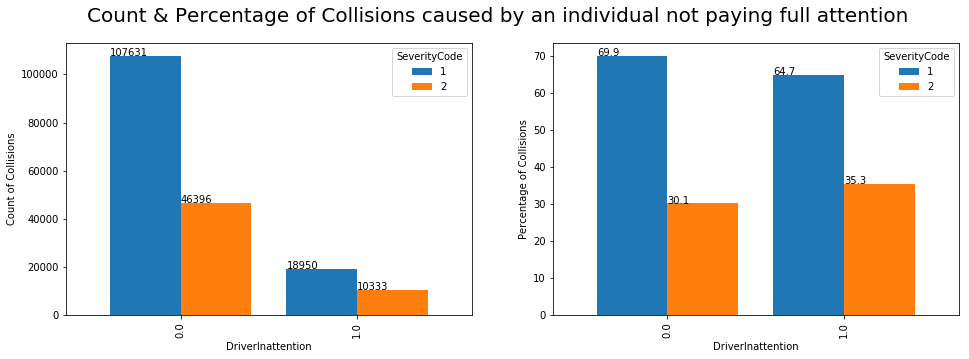

In [17]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions caused by an individual not paying full attention', size=20)

attention_pivot = data.pivot_table(
                        index='DriverInattention',
                        columns='SeverityCode',
                        aggfunc='size')
attention_plot1 = attention_pivot.plot(kind='bar', width=0.8, ax = axes[0])
attention_plot1.set_ylabel('Count of Collisions')
for p in attention_plot1.patches:
    attention_plot1.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
attention_plot1

attention_pivot = data.pivot_table(
                        index='DriverInattention',
                        columns='SeverityCode',
                        aggfunc='size')
attention_pivot = attention_pivot.div(attention_pivot.sum(1),0) * 100
attention_pivot = attention_pivot.round(1)
attention_plot2 = attention_pivot.plot(kind='bar', width=0.8, ax = axes[1])
attention_plot2.set_ylabel('Percentage of Collisions')
for p in attention_plot2.patches:
    attention_plot2.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

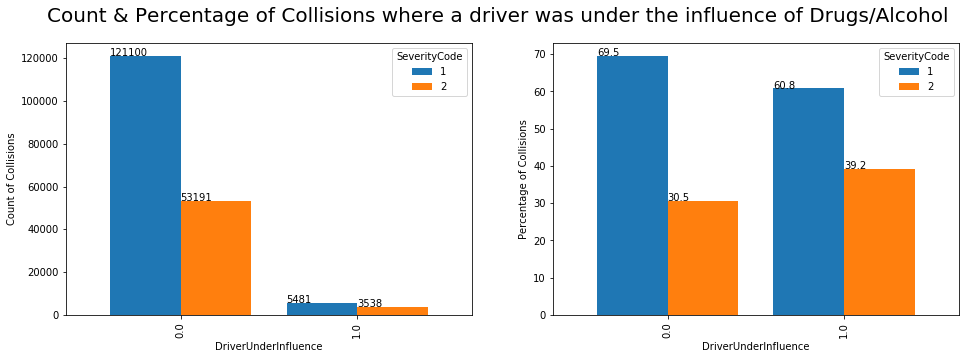

In [18]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions where a driver was under the influence of Drugs/Alcohol', size=20)

underinfl_pivot = data.pivot_table(
                        index='DriverUnderInfluence',
                        columns='SeverityCode',
                        aggfunc='size')
underinfl_plot = underinfl_pivot.plot(kind='bar', width=0.8, ax = axes[0])
underinfl_plot.set_ylabel('Count of Collisions')
for p in underinfl_plot.patches:
    underinfl_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
underinfl_plot

underinfl_pivot = data.pivot_table(
                        index='DriverUnderInfluence',
                        columns='SeverityCode',
                        aggfunc='size')
underinfl_pivot = underinfl_pivot.div(underinfl_pivot.sum(1),0) * 100
underinfl_pivot = underinfl_pivot.round(1)
underinfl_plot = underinfl_pivot.plot(kind='bar', width=0.8, ax = axes[1])
underinfl_plot.set_ylabel('Percentage of Collisions')
for p in underinfl_plot.patches:
    underinfl_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

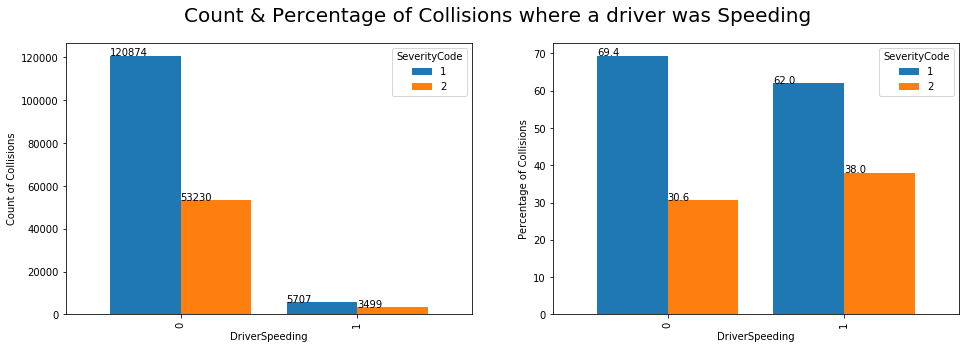

In [19]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions where a driver was Speeding', size=20)

speed_pivot = data.pivot_table(
                        index='DriverSpeeding',
                        columns='SeverityCode',
                        aggfunc='size')
speed_plot = speed_pivot.plot(kind='bar', width=0.8, ax = axes[0])
speed_plot.set_ylabel('Count of Collisions')
for p in speed_plot.patches:
    speed_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
speed_plot

speed_pivot = data.pivot_table(
                        index='DriverSpeeding',
                        columns='SeverityCode',
                        aggfunc='size')
speed_pivot = speed_pivot.div(speed_pivot.sum(1),0) * 100
speed_pivot = speed_pivot.round(1)
speed_plot = speed_pivot.plot(kind='bar', width=0.8, ax = axes[1])
speed_plot.set_ylabel('Percentage of Collisions')
for p in speed_plot.patches:
    speed_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

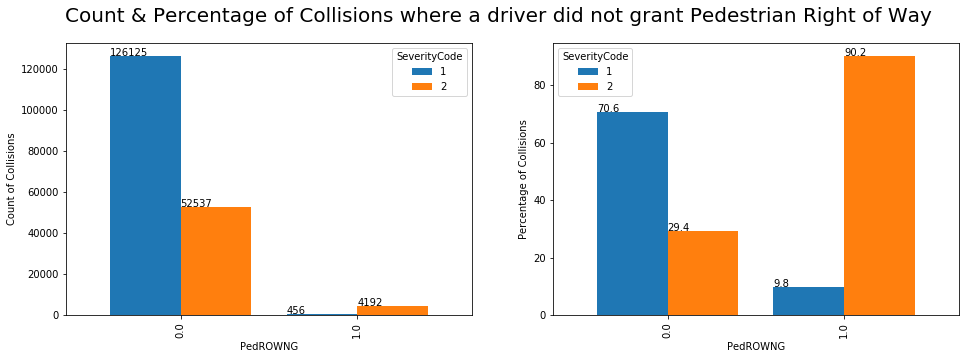

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions where a driver did not grant Pedestrian Right of Way', size=20)

row_pivot = data.pivot_table(
                        index='PedROWNG',
                        columns='SeverityCode',
                        aggfunc='size')
row_plot = row_pivot.plot(kind='bar', width=0.8, ax = axes[0])
row_plot.set_ylabel('Count of Collisions')
for p in row_plot.patches:
    row_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
row_plot

row_pivot = data.pivot_table(
                        index='PedROWNG',
                        columns='SeverityCode',
                        aggfunc='size')
row_pivot = row_pivot.div(row_pivot.sum(1),0) * 100
row_pivot = row_pivot.round(1)
row_plot = row_pivot.plot(kind='bar', width=0.8, ax = axes[1])
row_plot.set_ylabel('Percentage of Collisions')
for p in row_plot.patches:
    row_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

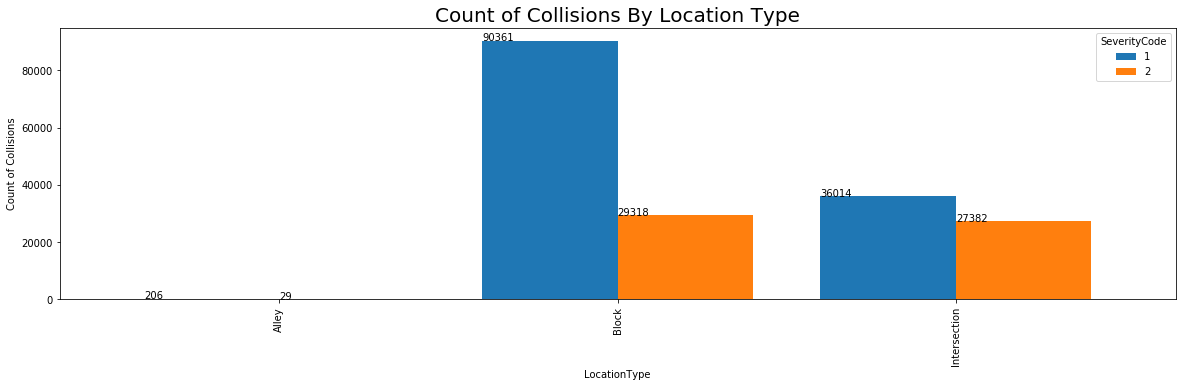

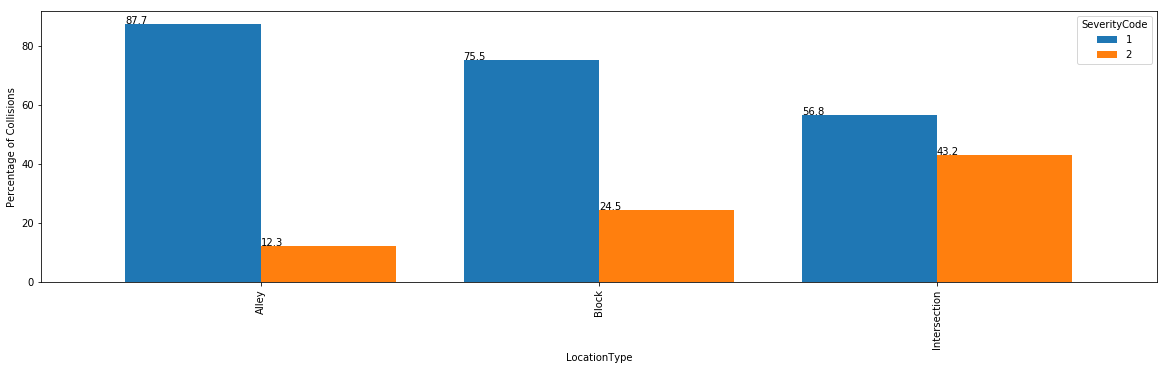

In [21]:
addr_pivot = data.pivot_table(
                        index='LocationType',
                        columns='SeverityCode',
                        aggfunc='size')
addr_plot = addr_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
addr_plot.set_ylabel('Count of Collisions')
addr_plot.set_title('Count of Collisions By Location Type', size=20)
for p in addr_plot.patches:
    addr_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
addr_plot

addr_pivot = data.pivot_table(
                        index='LocationType',
                        columns='SeverityCode',
                        aggfunc='size')
addr_pivot = addr_pivot.div(addr_pivot.sum(1),0) * 100
addr_pivot = addr_pivot.round(1)
addr_plot = addr_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
addr_plot.set_ylabel('Percentage of Collisions')
for p in addr_plot.patches:
    addr_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

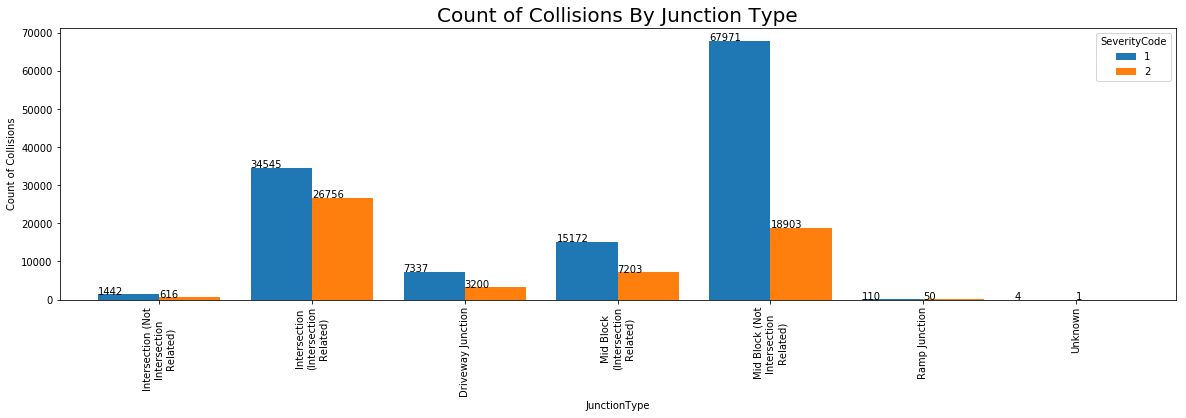

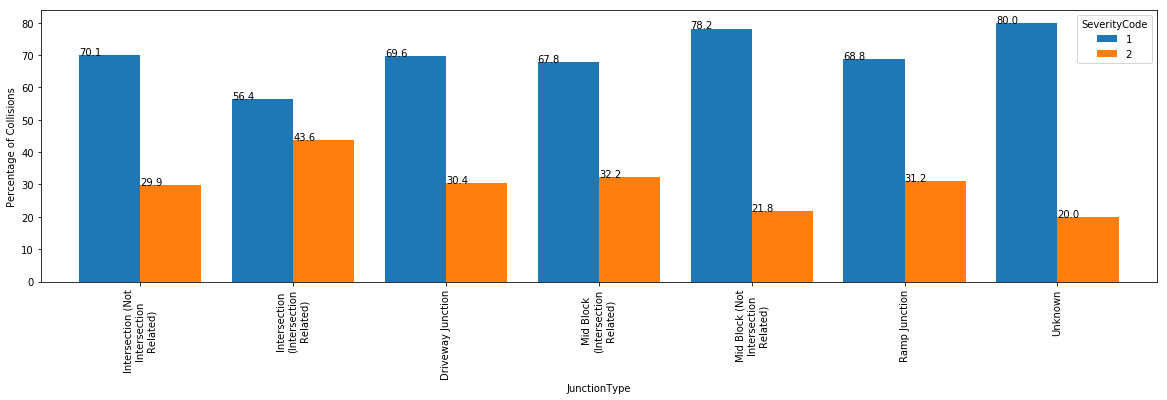

In [22]:
from textwrap import wrap
labels = ['Intersection (Not Intersection Related)', 'Intersection (Intersection Related)','Driveway Junction','Mid Block (Intersection Related)','Mid Block (Not Intersection Related)','Ramp Junction','Unknown']
labels = [ '\n'.join(wrap(l, 20)) for l in labels ]

junc_pivot = data.pivot_table(
                        index='JunctionType',
                        columns='SeverityCode',
                        aggfunc='size')
junc_plot = junc_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
junc_plot.set_ylabel('Count of Collisions')
junc_plot.set_xticklabels(labels)
junc_plot.set_title('Count of Collisions By Junction Type', size=20)
for p in junc_plot.patches:
    junc_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
junc_plot

junc_pivot = data.pivot_table(
                        index='JunctionType',
                        columns='SeverityCode',
                        aggfunc='size')
junc_pivot = junc_pivot.div(junc_pivot.sum(1),0) * 100
junc_pivot = junc_pivot.round(1)
junc_plot = junc_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
junc_plot.set_ylabel('Percentage of Collisions')
junc_plot.set_xticklabels(labels)
for p in junc_plot.patches:
    junc_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

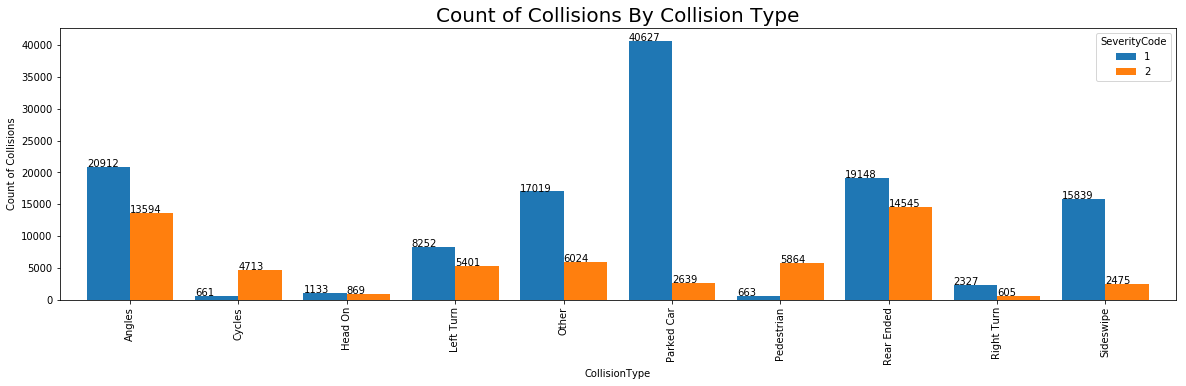

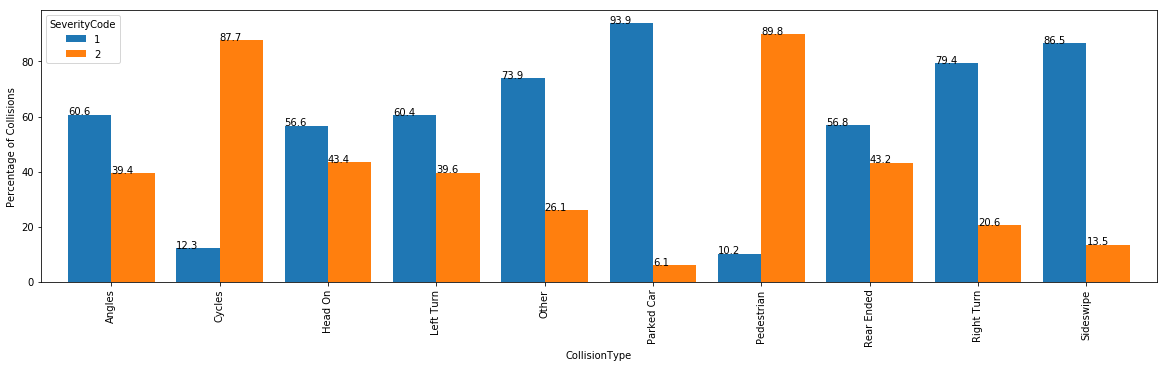

In [23]:
coll_pivot = data.pivot_table(
                        index='CollisionType',
                        columns='SeverityCode',
                        aggfunc='size')
coll_plot = coll_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
coll_plot.set_ylabel('Count of Collisions')
coll_plot.set_title('Count of Collisions By Collision Type', size=20)
for p in coll_plot.patches:
    coll_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
coll_plot

coll_pivot = data.pivot_table(
                        index='CollisionType',
                        columns='SeverityCode',
                        aggfunc='size')
coll_pivot = coll_pivot.div(coll_pivot.sum(1),0) * 100
coll_pivot = coll_pivot.round(1)
coll_plot = coll_pivot.plot(kind='bar', width=0.8,figsize=(20,5))
coll_plot.set_ylabel('Percentage of Collisions')
for p in coll_plot.patches:
    coll_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

In [24]:
def personcount(row):
    if row['PersonCount'] > 5:
        val = '6+'
    else:
        val = str(row['PersonCount'])
    return val

def pedcount(row):
    if row['PedestrianCount'] > 0:
        val = '1+'
    else:
        val = str(row['PedestrianCount'])
    return val

def cyclecount(row):
    if row['CyclistCount'] > 0:
        val = '1+'
    else:
        val = str(row['CyclistCount'])
    return val

def vehiclecount(row):
    if row['VehicleCount'] > 2:
        val = '3+'
    else:
        val = str(row['VehicleCount'])
    return val

In [25]:
data['PersonCount'] = data.apply(personcount, axis=1)
data['PedestrianCount'] = data.apply(pedcount, axis=1)
data['CyclistCount'] = data.apply(cyclecount, axis=1)
data['VehicleCount'] = data.apply(vehiclecount, axis=1)

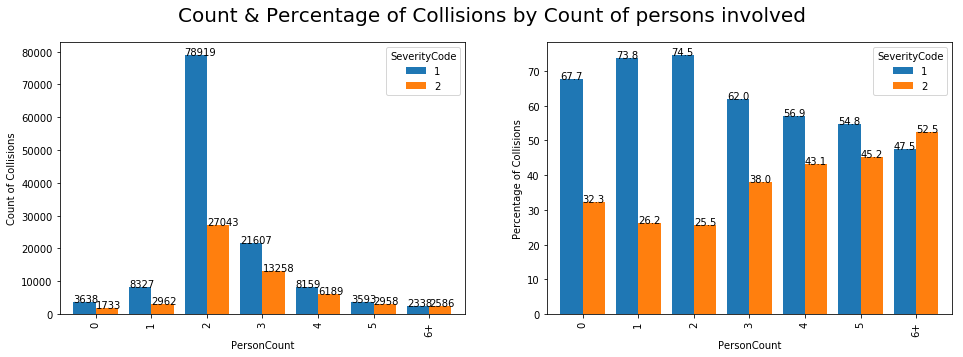

In [26]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions by Count of persons involved', size=20)

person_pivot = data.pivot_table(
                        index='PersonCount',
                        columns='SeverityCode',
                        aggfunc='size')
person_plot = person_pivot.plot(kind='bar', width=0.8, ax = axes[0])
person_plot.set_ylabel('Count of Collisions')
for p in person_plot.patches:
    person_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
person_plot

person_pivot = data.pivot_table(
                        index='PersonCount',
                        columns='SeverityCode',
                        aggfunc='size')
person_pivot = person_pivot.div(person_pivot.sum(1),0) * 100
person_pivot = person_pivot.round(1)
person_plot = person_pivot.plot(kind='bar', width=0.8,ax = axes[1])
person_plot.set_ylabel('Percentage of Collisions')
for p in person_plot.patches:
    person_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

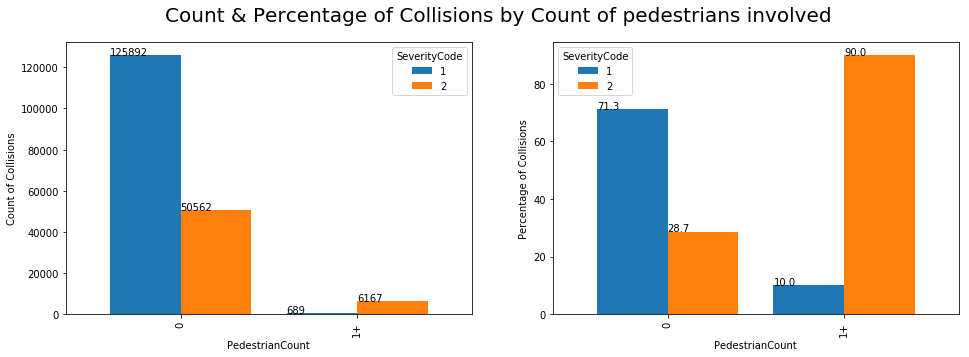

In [27]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions by Count of pedestrians involved', size=20)

ped_pivot = data.pivot_table(
                        index='PedestrianCount',
                        columns='SeverityCode',
                        aggfunc='size')
ped_plot = ped_pivot.plot(kind='bar', width=0.8,ax = axes[0])
ped_plot.set_ylabel('Count of Collisions')
for p in ped_plot.patches:
    ped_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
ped_plot

ped_pivot = data.pivot_table(
                        index='PedestrianCount',
                        columns='SeverityCode',
                        aggfunc='size')
ped_pivot = ped_pivot.div(ped_pivot.sum(1),0) * 100
ped_pivot = ped_pivot.round(1)
ped_plot = ped_pivot.plot(kind='bar', width=0.8,ax = axes[1])
ped_plot.set_ylabel('Percentage of Collisions')
for p in ped_plot.patches:
    ped_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

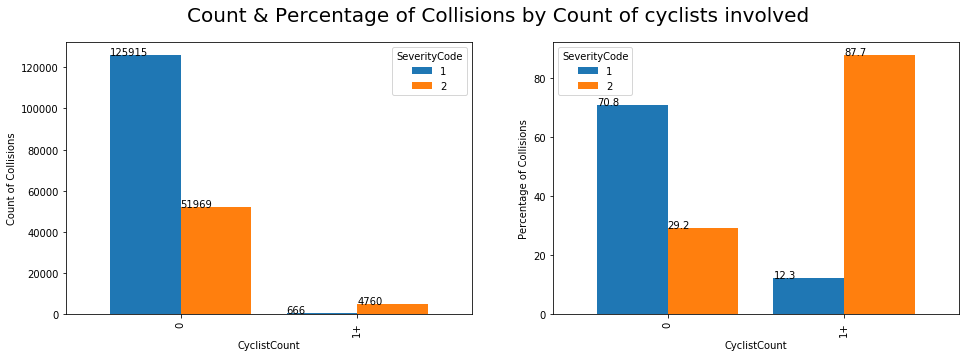

In [28]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions by Count of cyclists involved', size=20)

cycle_pivot = data.pivot_table(
                        index='CyclistCount',
                        columns='SeverityCode',
                        aggfunc='size')
cycle_plot = cycle_pivot.plot(kind='bar', width=0.8,ax = axes[0])
cycle_plot.set_ylabel('Count of Collisions')
for p in cycle_plot.patches:
    cycle_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
cycle_plot

cycle_pivot = data.pivot_table(
                        index='CyclistCount',
                        columns='SeverityCode',
                        aggfunc='size')
cycle_pivot = cycle_pivot.div(cycle_pivot.sum(1),0) * 100
cycle_pivot = cycle_pivot.round(1)
cycle_plot = cycle_pivot.plot(kind='bar', width=0.8,ax = axes[1])
cycle_plot.set_ylabel('Percentage of Collisions')
for p in cycle_plot.patches:
    cycle_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

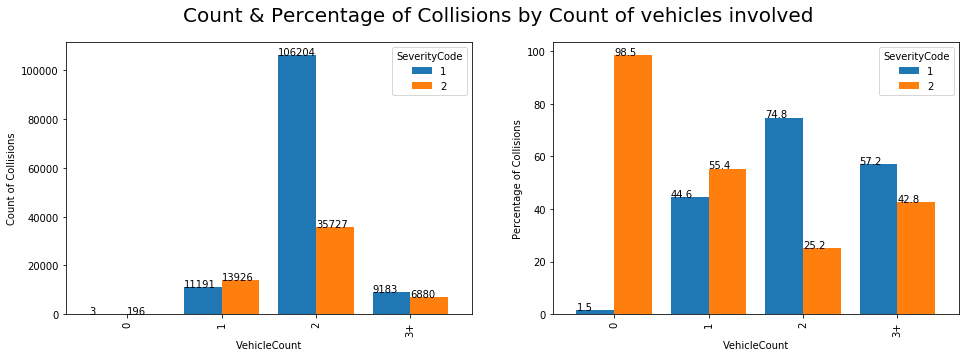

In [29]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(16,5))
fig.suptitle('Count & Percentage of Collisions by Count of vehicles involved', size=20)

veh_pivot = data.pivot_table(
                        index='VehicleCount',
                        columns='SeverityCode',
                        aggfunc='size')
veh_plot = veh_pivot.plot(kind='bar', width=0.8, ax = axes[0])
veh_plot.set_ylabel('Count of Collisions')
for p in veh_plot.patches:
    veh_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))
veh_plot

veh_pivot = data.pivot_table(
                        index='VehicleCount',
                        columns='SeverityCode',
                        aggfunc='size')
veh_pivot = veh_pivot.div(veh_pivot.sum(1),0) * 100
veh_pivot = veh_pivot.round(1)
veh_plot = veh_pivot.plot(kind='bar', width=0.8, ax = axes[1])
veh_plot.set_ylabel('Percentage of Collisions')
for p in veh_plot.patches:
    veh_plot.annotate(str(p.get_height()),(p.get_x(), p.get_height()))

In [30]:
#Create map of Seattle
#seattle_map = folium.Map(location=[47.619542517688615, -122.33051843904114],zoom_start=12,width=1400,height=1000)
#Create feature group for collision points
#incidents = folium.map.FeatureGroup()

#first_500_rows = data[:500]

# loop through the collision points, plotting them all on the map
#for lat, lng, in zip(first_500_rows.Y, first_500_rows.X):
#    incidents.add_child(
#        folium.features.CircleMarker(
#            [lat, lng],
#            radius=4,
#            color='yellow',
#            fill=True,
#            fill_color='blue',
#            fill_opacity=0.6
#        )
#    )
#seattle_map.add_child(incidents)
#seattle_map

In [31]:
# Pulling in only the columns required for the model
model_data = data[['SeverityCode','Month','DayOfWeek','Weather','RoadCondition','LightCondition']]
print("Before removing unknowns: ",model_data.shape)
#Remove "Unknown" and "Other" values from data
model_data = model_data[model_data.Weather != 'Unknown']
model_data = model_data[model_data.Weather != 'Other']
model_data = model_data[model_data.RoadCondition != 'Unknown']
model_data = model_data[model_data.RoadCondition != 'Other']
model_data = model_data[model_data.LightCondition != 'Unknown']
print("Before removing unknowns: ",model_data.shape)
#Convert Categorical columns into numeric using get_dummies
model_data[pd.get_dummies(model_data['Weather']).columns] = pd.get_dummies(model_data['Weather'])
model_data.drop(['Weather'], axis=1, inplace=True)

model_data[pd.get_dummies(model_data['RoadCondition']).columns] = pd.get_dummies(model_data['RoadCondition'])
model_data.drop(['RoadCondition'], axis=1, inplace=True)

model_data[pd.get_dummies(model_data['LightCondition']).columns] = pd.get_dummies(model_data['LightCondition'])
model_data.drop(['LightCondition'], axis=1, inplace=True)

#model_data.iloc[:,:20].head()

Before removing unknowns:  (183310, 6)
Before removing unknowns:  (167495, 6)


In [32]:
X = model_data.drop(['SeverityCode'],axis=1)
X = preprocessing.StandardScaler().fit(X).transform(X)
Y = model_data['SeverityCode']
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, train_size=0.8,test_size=0.2)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


Train set: (133996, 26) (133996,)
Test set: (33499, 26) (33499,)


/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:2: DataConversionWarning: Data with input dtype uint8, int64 were all converted to float64 by StandardScaler.
  from ipykernel import kernelapp as app


In [33]:
import time
import datetime
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print(st)

error = []

# Calculating error for K values between 1 and 40
#for i in range(1, 50):
#    knn = KNeighborsClassifier(n_neighbors=i)
#    knn.fit(X_train, y_train)
#    pred_i = knn.predict(X_test)
#    error.append(np.mean(pred_i != y_test))
#    ts = time.time()
#    st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
#    print(st)
#    print(error)
    
# Between 1 and 19 best K is 16 (0.342)
# Between 15 and 30 best K is 24 (0.337)
# Between 25 and 40 best K is 36 (0.329)
# Between 35 and 50 best K is  (0.333)


2020-09-08 17:03:01


In [34]:
knn = KNeighborsClassifier(n_neighbors=36)
knn.fit(X_train, y_train)
yhat_knn = knn.predict(X_test)
error.append(np.mean(yhat_knn != y_test))
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print(st)
print(error)

2020-09-08 17:10:11
[0.3318009492820681]


In [35]:
#plt.figure(figsize=(12, 6))
#plt.plot(range(36), error, color='red', linestyle='dashed', marker='o',
#         markerfacecolor='blue', markersize=10)
#plt.title('Error Rate K Value')
#plt.xlabel('K Value')
#plt.ylabel('Mean Error')

In [36]:
dt = DecisionTreeClassifier(criterion = "entropy", max_depth=15)
dt.fit(X_train, y_train)
yhat_dt = dt.predict(X_test)
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print(st)

2020-09-08 17:10:12


In [37]:
lr = LogisticRegression()
lr.fit(X_train,y_train)
yhat_lr=lr.predict(X_test)
ts = time.time()
st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
print(st)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


2020-09-08 17:10:13


In [38]:
#clf = svm.SVC(kernel = "linear")
#clf.fit(X_train, y_train)
#yhat_svm = clf.predict(X_test)
#ts = time.time()
#st = datetime.datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
#print(st)

In [39]:
from sklearn.metrics import classification_report
print (classification_report(y_test, yhat_knn))
print (classification_report(y_test, yhat_dt))
print (classification_report(y_test, yhat_lr))


              precision    recall  f1-score   support

           1       0.67      0.99      0.80     22508
           2       0.35      0.01      0.02     10991

   micro avg       0.67      0.67      0.67     33499
   macro avg       0.51      0.50      0.41     33499
weighted avg       0.57      0.67      0.55     33499

              precision    recall  f1-score   support

           1       0.67      0.99      0.80     22508
           2       0.28      0.01      0.01     10991

   micro avg       0.67      0.67      0.67     33499
   macro avg       0.48      0.50      0.41     33499
weighted avg       0.54      0.67      0.54     33499

              precision    recall  f1-score   support

           1       0.67      1.00      0.80     22508
           2       1.00      0.00      0.00     10991

   micro avg       0.67      0.67      0.67     33499
   macro avg       0.84      0.50      0.40     33499
weighted avg       0.78      0.67      0.54     33499



In [40]:
from sklearn.metrics import jaccard_similarity_score
print("KNN Jaccard Score:",jaccard_similarity_score(y_test, yhat_knn))
print("Decision Tree Jaccard Score:",jaccard_similarity_score(y_test, yhat_dt))
print("Logistic Regression Jaccard Score:",jaccard_similarity_score(y_test, yhat_lr))

KNN Jaccard Score: 0.6681990507179318
Decision Tree Jaccard Score: 0.6681990507179318
Logistic Regression Jaccard Score: 0.6719305053882205


In [41]:
from sklearn.metrics import f1_score
print("KNN F1 Score:",f1_score(y_test, yhat_knn, average='weighted'))
print("Decision Tree F1 Score:",f1_score(y_test, yhat_dt, average='weighted'))
print("Logistic Regression F1 Score:",f1_score(y_test, yhat_lr, average='weighted'))

KNN F1 Score: 0.5457529499220225
Decision Tree F1 Score: 0.5424808176149294
Logistic Regression F1 Score: 0.5401139746929815


In [43]:
from sklearn.metrics import accuracy_score
print("KNN accuracy: ", accuracy_score(y_test, yhat_knn))
print("Decision Tree accuracy:", accuracy_score(y_test, yhat_dt))
print("Logistic Regression accuracy: ", accuracy_score(y_test, yhat_lr))

KNN accuracy:  0.6681990507179318
Decision Tree accuracy: 0.6681990507179318
Logistic Regression accuracy:  0.6719305053882205
